<h1><u><center> Economic Scenario Generator Project - Projet DDEFI </center></u></h1>
<img src = "https://www.econostrum.info/photo/art/grande/36648656-32651177.jpg?v=1566465679" 
     title = "NASDAQ Logo" alt = "Nasdaq Logo" width="300">

<h3><center> Anaïs Auzanneau / Alison Cortesi / Germain Lefebvre / Florent Morin / Vincent Bilger</center></h3>

<h4><center> - </h4></center>
<h4><center> École Centrale Marseille </h4></center>

### Sommaire  <a class="anchor" id="sommaire"></a>

* [0 - Importation des ressources](#chapter0)
* [I - Conversion des données en rendements logarithmiques](#chapter1)
    * [Complétement : Modélisation d'une portefeuille d'actions pondéré](#chapter1.complement)
    
* [II - Préparation de notre data set pour la simulation ](#chapter2)

* [III - Premières modélisations - Plusieurs méthodes paramétriques](#chapter3)
    * [III.1  Préparation de 3 modèles paramétriques](#chapter3.section1) 
        * [III.1.1 - Modèle AR(1)](#chapter3.section1.1)
        * [II.1.2 - Modèle GARCH(1,1)](#chapter3.section1.2)
        * [III.1.3 - Modèle EGARCH(1,1)](#chapter3.section1.3)
    * [III.2 - Simulations grâce à nos modèles](#chapter3.section2)
        * [II.2.1 - Simulation avec AR(1)](#chapter3.section2.1)
        * [III.2.2 - Simulation avec EGARCH(1,1)](#chapter3.section2.2)
        * [III.2.3 - Simulation avec GARCH(1,1)](#chapter3.section2.3)
        * [III.2.4 - Simulation avec FHS (AR et GARCH)](#chapter3.section2.4)
        
* [IV- Bootstrapping & 1ère analyse](#chapter4)
    * [IV.1 - Bootstrapping](#chapter4.section1)
    * [IV.2 - Première analyse](#chapter4.section2)
    * [IV.3 - Comparaison avec les valeurs réelles](#chapter4.section3)
    
* [V - Fonction Prediction_Boostrapping](#chapter5)

* [VI - Fonction de performance](#chapter6) 
    * [VI.1 - Fonctions de mesures](#chapter6.section1)
    * [VI.2 - Fonction Describe](#chapter6.section2)
    * [VI.3 - Comparaison des prévisions par boostrapping et des modèles AR(1), GARCH(1,1) et AR(1)-GARCH(1,1)](#chapter6.section3)

* [VII - Filtred Historical Simulation ](#chapter7)

## 0 - Importation des ressources <a class="anchor" id="chapter0"></a>

In [3]:
# conda install -c saravji pmdarima
# conda install -c conda-forge statsmodels

import pandas as pd                                       #Used in all section
import numpy as np                                        #Used in all section
from math import *                                        #Used in all section
import datetime                                           #Used in section 0
from datetime import date                                 #Used in section 0
from statsmodels.tsa.arima_model import ARIMA             #Used in section 3.1.1
import pmdarima as pm                                     #Used in section 3.1.1              
from pmdarima.arima import ARIMA                          #Used in section 3.1.1
from statsmodels.graphics.tsaplots import plot_acf        #Used in section 3.1.2 et 3.1.3
from arch import arch_model                               #Used in section 3.1.2 et 3.1.3
import random                                             #Used in section 4 and 5
import matplotlib.pyplot as plt                           #Used in all section
import plotly.graph_objects as go                         #Used in section 4.3
plt.style.use('ggplot')
from scipy import stats                                   #Used in section 6.1
from scipy.stats import f_oneway                          #Used in section 6.1 
from scipy.stats import mannwhitneyu                      #Used in section 6.1
from scipy.stats import wasserstein_distance              #Used in section 6.1
from scipy.stats import wilcoxon                          #Used in section 6.1 

$! Attention !$ Ne pas oublier de changer le chemin ci-dessous en fonction de l'utilisateur afin d'arriver au fichier contenant les bases de données.

In [4]:
# root_path = 'C:/Users/anais/Documents/Centrale/Cours/3A/DDEFi/Projet DDEFi/Ressources/Data/'      #Anais
# root_path = 'C:/Users/33649/Desktop/A3/Projet DDEFI/BP2S/Code_Data_2020/'                         #Germain
root_path = 'C:/Users/flomo/Desktop/Projet BNP/Data/'                                             #Florent
# root_path = 'C:/Users/Vincent/Desktop/PROJET DDEFI/DATA/'                                         #Vincent
# root_path = 'C:/Users/alisoncortesi/Desktop/ECM_3A/OPT_DDEFI/TC_PROJDDEFI                         #Alison
# root_path = 'D:/Utilisateurs/JLEQ/BP2S/Datas/'                                                    #Julien                                                          #Julien

Importation de nos 3 bases d'indices afin de pouvoir selectionner les données souhaitées.

In [5]:
Actions = pd.read_csv(root_path+'BDD_Index.csv')
Taux = pd.read_csv(root_path+'BDD_Rates.csv')
Echanges = pd.read_csv(root_path+'BDD_Exchange.csv')

Actions['Date'] = pd.to_datetime(Actions['Date'])
Actions = Actions.set_index(keys = 'Date', drop = True)

Taux['Date'] = pd.to_datetime(Taux['Date'])
Taux = Taux.set_index(keys = 'Date', drop = True)

Echanges['Date'] = pd.to_datetime(Echanges['Date'])
Echanges = Echanges.set_index(keys = 'Date', drop = True)

Afin de mieux visualiser les données à notre disposition, nous commençons par tracer l'évolution temporelle de nos données brutes.

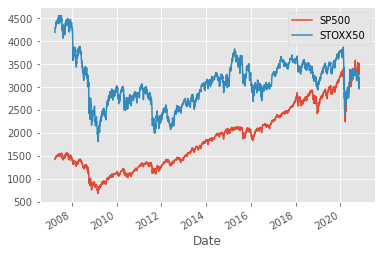

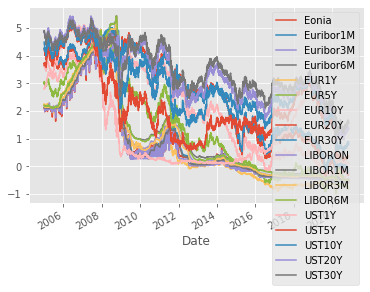

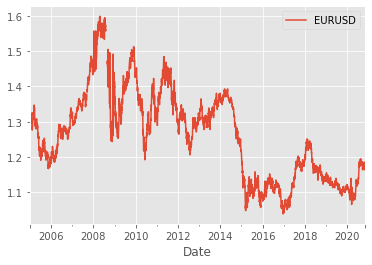

In [6]:
Actions.plot()
Taux.plot()
Echanges.plot()

Afin de pouvoir étudier un panel important de données, et notamment des taux, nous importons ici un grand nombre de fichier.
Dans un premier temps, toutes les données importées ne seront pas utilisées.
Dans les 6 prochains chapitres, nous ne nous interesserons qu'aux deux indices STOXX50 et S&P500.

Ci-dessous, un schéma récapitulatif des données aggrégées : 

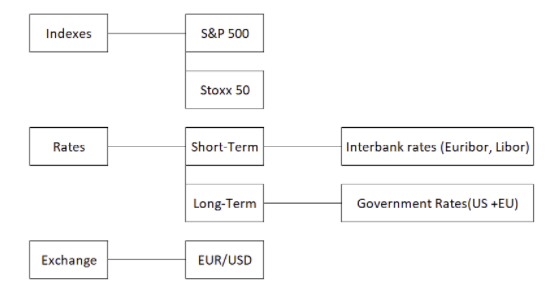

In [7]:
# On définit nos deux actions dans des variables explicites
SP500 = Actions[['SP500']]

STOXX50 = Actions[['STOXX50']]

## I - Conversion des données en rendements logarithmiques <a class="anchor" id="chapter1"></a>

[Retour Sommaire](#sommaire)

On commence par normaliser les donneés en divisant chaque donnée par la valeur initiale de la série.

$$ r_{t} = \frac{Data_{t}}{Data_{0}} $$

Puis on passe au logarithme : 

$$ Return(t) = \ln(1 + r_{t}) $$


##### Liens utiles : 
* https://stackoverflow.com/questions/49352551/pandas-how-to-get-close-price-from-returns
* https://subscription.packtpub.com/book/data/9781789618518/1/ch01lvl1sec05/converting-prices-to-returns

In [8]:
#On calcul le pourcentage de variation pour chacune nos deux actions :
r_S50 = STOXX50.pct_change().dropna()
r_SP = SP500.pct_change().dropna()

#On prend le logarithme pour obtenir nos rendements logarithmiques
returns_S50 = np.log(1 + r_S50).mean(axis=1)
returns_SP = np.log(1 + r_SP)

Text(0.5, 1.0, 'Daily Logarithmic Returns for S&P500 Index')

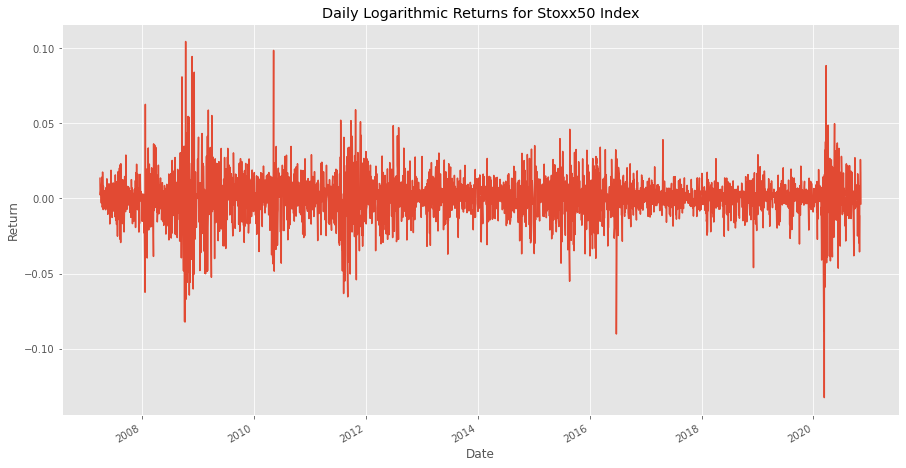

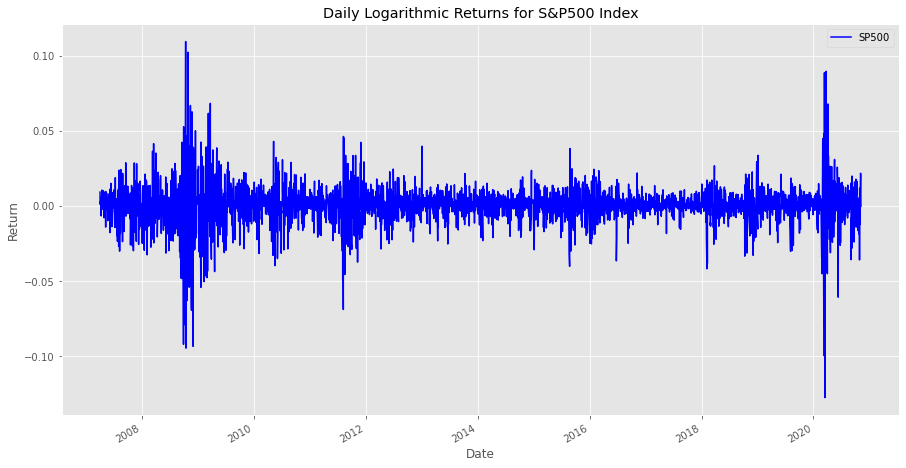

In [9]:
returns_S50.plot(figsize=(15, 8))
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Daily Logarithmic Returns for Stoxx50 Index')

returns_SP.plot(figsize=(15,8),color='b')
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('Daily Logarithmic Returns for S&P500 Index')

On peut maintenant afficher le rendement logarithmique journalier de nos actions : 

<u>Remarque:</u> On voit bien les fortes varations en 2009 (crise financière) et idem en début 2020 (crise du COVID-19)

#### Complétement : Modélisation d'une portefeuille d'actions pondéré <a class="anchor" id="chapter1.complement"></a>

Afin d'élargir l'utilité de notre projet, nous nous sommes laissés la possibilité de modéliser non pas une unique action mais aussi un portefeuille d'actions pondéré.

La modélisation de ce portefeuille est réalisée ci-dessous avec une pondération équivalente (50% - 50%) : 

In [10]:
# Portefeuille pondéré (répartition à 50%)
#data_pf=Actions[['STOXX50','SP500']]
#data_pf.set_index(Actions['Date'],inplace=True)

#data_pf['Portfolio']=data_pf.mean(axis=1)

#Comme dans la partie précédente, on prend le pourcentage puis on passe au logarithme
#r_portfolio = data_pf.pct_change().dropna().mean(axis=1)
returns = np.log(1 + r_S50)

#print(data_pf)

In [11]:
#Affichage des différentes courbes qui composent notre portfolio 
#data_pf.plot(figsize=(15, 8))
#plt.legend()
#plt.show()

## II - Préparation de notre data set pour la simulation <a class="anchor" id="chapter2"></a>

[Retour Sommaire](#sommaire)

Dans la suite de ce paragraphe, on utilisera <strong> l'action Stoxx50 </strong>, plus précisément son <strong> rendement logarithmique </strong> associé.

On commence par séparer notre data set en deux.

- La première partie (80%) correspond au Training Set
- La seconde partie (20%) correspond au Testing Set

In [12]:
# pour STOXX50 (et plus pour le portefeuille pondéré)
#séparation en data training et data test
T=len(STOXX50.index)
T=int(np.floor(T*0.8))

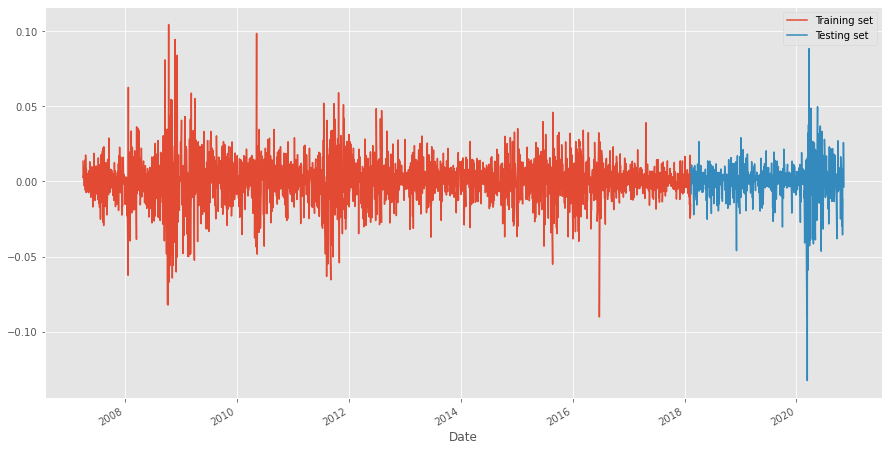

In [13]:
#On crée un fonction qui sépare les datas en training et testing set
def training (data):
    T=len(data.index)
    T=int(np.floor(T*0.8))
    training_data = data[0:T-1]
    return(training_data)
    
def testing (data):
    T=len(data.index)
    T=int(np.floor(T*0.8))
    testing_data = data[T:]
    return(testing_data)
    
#On regarde ce que ça donne sur les returns Stoxx50
training_data_S50=training(returns_S50)
testing_data_S50=testing(returns_S50)

training_data_S50.plot(figsize=(15, 8),label='Training set')
testing_data_S50.plot(figsize=(15, 8),label='Testing set')
plt.legend()

## III - Premières modélisations - Plusieurs méthodes paramétriques <a class="anchor" id="chapter3"></a>

[Retour Sommaire](#sommaire)

Nous avons voulu dans un premier temps réaliser des méthodes simples de modélisations et de prédictions. L'objectif était tout d'abord de manipuler nos set de données, mais aussi d'apprécier la performance de ces méthodes simples afin de travailler sur des méthodes plus compliquées.

Nous en avons sélectionné trois.


### III.1  Préparation de 3 modèles paramétriques<a class="anchor" id="chapter3.section1"></a>

### III.1.1 - Modèle ARMA(p,q) <a class="anchor" id="chapter3.section1.1"></a>

On rappelle la forme de ce modèle ci-dessous : 

$$ X_{t}= c+\sum _{{i=1}}^{p}\varphi _{i}X_{{t-i}}+\varepsilon _{t} + \sum _{i=1}^{q}\theta _{i}\varepsilon _{t-i}$$

où 
- $c$ : constante
- $\varepsilon _{t}$ : bruit blanc
- $\varphi _{i} $ , $ \theta _{i} $ : parametres du modèle 

Nous allons utiliser une fonction qui permet de retourner le meilleur processus ARIMA par minimisation du critére d'information AIC. Cette recherche de modèle n'est pas optimale mais elle nous permet de sélectionner très rapidement notre modèle pour la suite de nos travaux.

<u> Nb :</u> Documentation sur la fonction auto.arima : 
https://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html

In [14]:
#The Auto-arima function will propose the best Arma-GARCH model for our returns
def best_param_ARIMA(training_data,p_max,q_max):
    stepwise_fit = pm.auto_arima(training_data, start_p=1, start_q=1, max_p=p_max, max_q=q_max, m=1,
                             start_P=0, seasonal=False, d=0, D=0, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

    return(stepwise_fit.summary())


Nous prendrons pour exemple le training set réalisé avec les <strong> rendements logarithmiques du Stoxx50 </strong>, mais cela peut s'appliquer avec d'autres modèles pour des training set contenant d'autres actions.

In [15]:
# On fait tourner notre fonction sur notre training set 
best_param_ARIMA(training_data_S50,3,3)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-14777.033, Time=0.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-14778.252, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-14778.866, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-14779.193, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-14785.546, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-14785.885, Time=1.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-14784.160, Time=1.80 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-14787.800, Time=0.56 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-14788.396, Time=0.70 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-14786.511, Time=0.49 sec

Best model:  ARIMA(0,0,3)(0,0,0)[0]          
Total fit time: 6.240 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2669
Model:               SARIMAX(0, 0, 3)   Log Likelihood                7398.198
Date:                Sun, 13 Dec 2020   AIC                         -14788.396
Time:                        15:03:59   BIC                         -14764.838
Sample:                             0   HQIC                        -14779.872
                               - 2669                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0349      0.013     -2.712      0.007      -0.060      -0.010
ma.L2         -0.0557      0.012     -4.557      0.000      -0.080      -0.032
ma.L3         -0.0416      0.012     -3.467      0.001      -0.065      -0.018
sigma2         0.0002   3.54e-06     64.686      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       69.62   Jarque-Bera (JB):              2716.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Le meilleur processus ARMA pour modéliser notre rendement logarithmique du Stoxx50 est un processus MA(3).
Nous allons fitter notre série à ce processus puis réaliser une prédiction grâce à ce modèle.

##### Exemple de manipulation avec un processus ARMA (0,3)

In [16]:
# Fitting de notre modèle MA(3)
MA_fit_S50 = ARIMA(order=(0, 0, 3)).fit(training_data_S50)

#Résidus du modèle
residus_MA_S50 = MA_fit_S50.resid

# ! Warning ! Pour qu'il affiche le summary il faut executer cette cellule 2 fois.
# La première fois je reçois un message d'erreur mais la 2e fonctionne...
print(MA_fit_S50.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2669
Model:               SARIMAX(0, 0, 3)   Log Likelihood                7398.255
Date:                Sun, 13 Dec 2020   AIC                         -14786.511
Time:                        15:03:59   BIC                         -14757.063
Sample:                             0   HQIC                        -14775.855
                               - 2669                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -8.092e-05      0.000     -0.294      0.768      -0.001       0.000
ma.L1         -0.0349      0.013     -2.627      0.009      -0.061      -0.009
ma.L2         -0.0558      0.012     -4.518      0.0

Maintenant que notre modèle est construit, on récupère les paramètres estimés pour le modèle.

In [17]:
# volatilité du modèle MA(3), constante
vol_MA_S50 = MA_fit_S50.params()[-1]

#paramètres estimés par le modèle
phi_1 = MA_fit_S50.params()[1]
phi_2 = MA_fit_S50.params()[2]
phi_3 = MA_fit_S50.params()[3]

In [18]:
#Affichage des paramètres du systèmes
print('La volatilité du modèle est',vol_MA_S50)
print(' ')
print('Les paramètres estimés par ce modèle sont :')
print('phi.1 =', phi_1)
print('phi.2 =', phi_2)
print('phi.3 =', phi_3)

La volatilité du modèle est 0.00022886409676964038
 
Les paramètres estimés par ce modèle sont :
phi.1 = -0.034945702883102205
phi.2 = -0.05579467324374156
phi.3 = -0.041620911773243154


Nous utiliserons dans une partie ultérieur ce modèle pour réaliser des prédictions de scénarios.


### II.1.2 - Modèle GARCH(p,q)  <a class="anchor" id="chapter3.section1.2"></a>

[Retour Sommaire](#sommaire)

Comme précédement, nous allons utiliser une fonction de performance et nous allons déterminer les paramètres p et q optimaux pour notre modèle GARCH(p,q).

On rappelle le format général d'un modèle GARCH(p,q): 
$$ \sigma^{2}_{t} = \omega + \sum_{j=1}^{q}\alpha_{j}\epsilon^{2}_{t-j}  +  \sum_{j=1}^{p}\beta_{j}\sigma^{2}_{t-j}  $$

Par exemple, si p=q=1, cela signifie que :

$$ r_{t} = \mu + \epsilon_{t} $$

$$ \sigma^{2}_{t} = \omega + \alpha \epsilon^{2}_{t-1} + \beta \sigma^{2}_{t-1} $$

$$ \epsilon_{t} = \sigma_{t}e_{t} $$ 
with $ e_{t}\sim N(0,1) $

In [19]:
# Fonction de performance :

def best_param_garch(training_data,pmax,qmax):
    best_pq=[0,0]
    AIC = 0
    for p in range(1,pmax+1):
        for q in range(qmax+1):
            model = arch_model(training_data,p=p,q=q,rescale=False)
            fit = model.fit(update_freq=5,disp='off')
            if fit.aic<AIC:
                AIC = fit.aic
                best_pq[0]=p
                best_pq[1]=q
    return(best_pq)

On reprend de nouveau pour exemple avec le rendement logarithmique de l'action Stoxx50.

In [20]:
# GARCH Model (with constant mean) - Fonction de performance basée sur AIC
[p,q] = best_param_garch(training_data_S50,5,5)
print("Les meilleurs paramètres sont p="+str(p)+" et q="+str(q))

Les meilleurs paramètres sont p=1 et q=1


##### Exemple de manipulation avec un processus GARCH (1,1)

In [21]:
# Set up sur notre jeux de données du model GARCH selectioné par notre fonction de performance - GARCH(1,1)
garch_S50 = arch_model(returns_S50,p=p,q=q,rescale=False)
garch_fitted_S50 = garch_S50.fit(update_freq=5,disp='off')

# On retourne le récapitulatif de notre modèle 
print(garch_fitted_S50.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                9889.22
Distribution:                  Normal   AIC:                          -19770.4
Method:            Maximum Likelihood   BIC:                          -19746.0
                                        No. Observations:                 3338
Date:                Sun, Dec 13 2020   Df Residuals:                     3334
Time:                        15:04:08   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.3133e-04  5.309e-06     81.248      0.000 [4.

On récupère les paramètres estimés par le modèle de la même manière que pour le modèle ARMA(p,q).

In [22]:
#volatilité du modèle GARCH (p,q) - Ici dans notre cas exemple : GARCH(1,1)
vol_garch_S50 = garch_fitted_S50.conditional_volatility

#paramètres estimés par le modèle
omega = garch_fitted_S50.params[0]
alpha = garch_fitted_S50.params[1]
beta = garch_fitted_S50.params[2]
nu = garch_fitted_S50.params[3]

In [23]:
#Affichage de notre paramètres
print('Les paramètres estimés par ce modèle sont :')
print('omega =', omega)
print('alpha =', alpha)
print('beta =', beta)
print('nu =', nu)

Les paramètres estimés par ce modèle sont :
omega = 0.0004313269645936499
alpha = 4.482574099554145e-06
beta = 0.10000003420416798
nu = 0.8799998932796472


Nous utiliserons dans une partie ultérieur ce modèle pour réaliser des prédictions de scénarios.

### III.1.3 - Modèle EGARCH (p,q)  <a class="anchor" id="chapter3.section1.3"></a>

[Retour Sommaire](#sommaire)

Enfin, le troisième modèle que nous avons voulu  modéliser est un processus EGARCH. Nous rappellons ci-dessous les formes associées à ce modèle : 

$$ \epsilon_{t} = z\_{t} \sqrt{h_{t}} $$

$$ \log(h_{t}) = \alpha_{0} + a_{1} z_{t-i} + b_{1} (|z_{t-i}| - E (|z_{t-i}|)) + \beta_{1} \log(h_{t-1}) $$

où $ z_{t} $ : bruit faible ;

les paramètres pour ce systèmme : $\alpha_{0}$, $a_{1}$ ,  $b_{1}$ , $\beta_{1}$

avec $ a_{1} = \theta \alpha_{1} $ et $ b_{1} = \alpha_{1} \gamma  $


L'objectif de l'utilisation de ce processus était de diminuer l'asymétrie de la série temporelle étudiée. Vous trouverez ci-dessous quelques articles qui ont orienté nos démarches en ce sens.


#### Liens utiles : 
<https://vlab.stern.nyu.edu/docs/volatility/EGARCH>

<https://www.univ-orleans.fr/deg/masters/ESA/CH/Cours_Finance.pdf> 


Ce processus se base sur la même fonction de performance que dans la partie précédente. La seule différence concerne la modélisation de notre processus. La volatilié sera prise avec le paramètre prédéfini ('EGARCH') dans la librairie python que nous utilisons.

In [24]:
# GARCH Model (with constant mean) - Fonction de performance basée sur AIC
[p,q] = best_param_garch(training_data_S50,5,5)
print("Les meilleurs paramètres sont p="+str(p)+" et q="+str(q))

Les meilleurs paramètres sont p=1 et q=1


##### Exemple de manipulation avec un processus EGARCH (1,1)

In [25]:
#Modèle EGARCH(1,1)
modele_egarch_S50 = arch_model(training_data_S50, mean='Zero', vol='EGARCH', p=1, o=0, q=1, dist='StudentsT',rescale=False)

#Estimation des paramètres
modele_egarch_fit_S50 = modele_egarch_S50.fit(update_freq=5,disp='off')

#Résidus du modèle
residus_egarch_S50 = modele_egarch_fit_S50.resid

In [26]:
#Affichage du résumé du processus EGARCH(1,1)
print(modele_egarch_fit_S50.summary())

                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                7871.86
Distribution:      Standardized Student's t   AIC:                          -15735.7
Method:                  Maximum Likelihood   BIC:                          -15712.2
                                              No. Observations:                 2669
Date:                      Sun, Dec 13 2020   Df Residuals:                     2665
Time:                              15:04:16   Df Model:                            4
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega  

Comme précédement pour le modèle AR(1), on récupère les paramètres estimés par le modèle

In [27]:
#volatilité du modèle EGARCH(1,1)
vol_egarch_S50 = modele_egarch_fit_S50.conditional_volatility

#paramètres estimés par le modèle
omega = modele_egarch_fit_S50.params[0]
alpha = modele_egarch_fit_S50.params[1]
beta = modele_egarch_fit_S50.params[2]
nu = modele_egarch_fit_S50.params[3]

In [28]:
print('Les paramètres estimés par ce modèle sont :')
print('omega =', omega)
print('alpha =', alpha)
print('beta =', beta)
print('nu =', nu)

Les paramètres estimés par ce modèle sont :
omega = -0.1148588975613026
alpha = 0.1953468342678826
beta = 0.9857819441532042
nu = 7.031412505846184


### III.2 - Simulations grâce à nos modèles <a class="anchor" id="chapter3.section2"></a>

[Retour Sommaire](#sommaire)

### III.2.1 - Simulation avec ARMA (p,q) - Exemple : MA(3) <a class="anchor" id="chapter3.section2.1"></a>

Pour le moment, nous avons réalisés seulement deux simulations. Nous avons choisis des horizons proches, à savoir 20 et 50 jours. Nous rappellons ci-dessous l'équation du modèle MA(3) utilisé pour réaliser la simulation.

#### Equation modèle MA(3) :
$$r(t)= \epsilon(t) + \varphi_{1}*\epsilon(t-1) + \varphi_{2}*\epsilon(t-2) + \varphi_{3}*\epsilon(t-3) $$

In [29]:
# def prediction_AR(period):
#     X_t=0
#     returns=[]
#     for i in range(period):
#         epsilon_t = vol_AR * np.random.standard_normal()
#         X_forecast = mu + theta*X_t + epsilon_t
#         returns.append(X_forecast)
#         X_t = X_forecast
#     return returns


def prediction_MA_3(volatility, period) :
    X_t=0
    returns = [0,0,0]
    epsilon = []
    for i in range (3):
        epsilon.append(volatility * np.random.standard_normal())
    for i in range(3, period):
        epsilon_t = volatility * np.random.standard_normal()
        X_forecast = epsilon_t + phi_1*epsilon[i-1] + phi_2*epsilon[i-2] + phi_3*epsilon[i-3]
        epsilon.append(epsilon_t)
        returns.append(X_forecast)
        X_t = X_forecast
    return (returns)

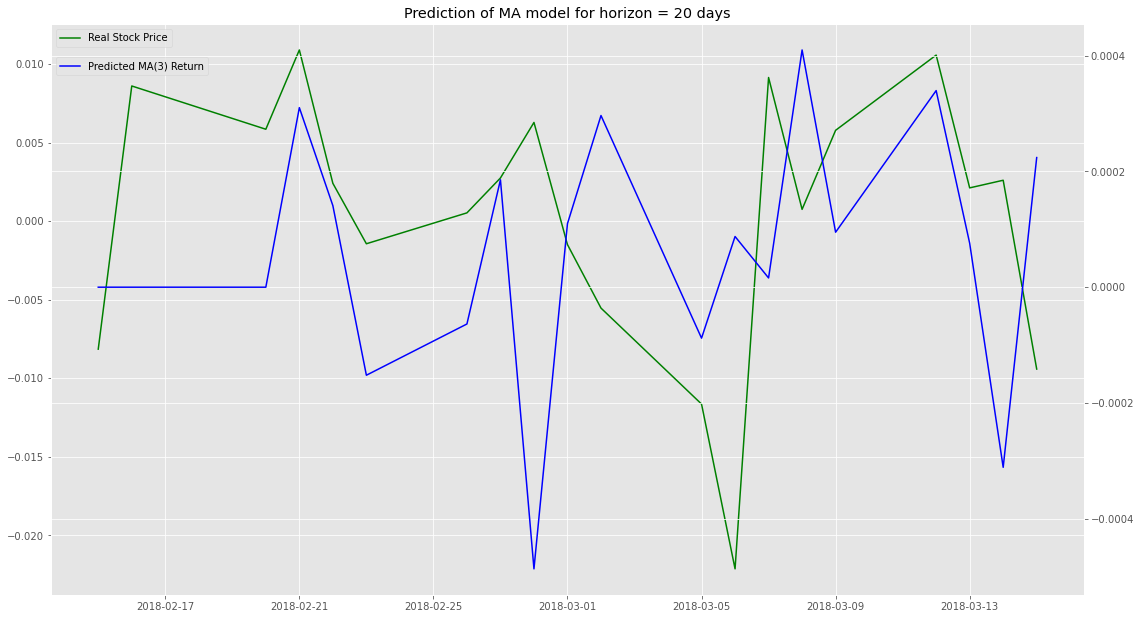

In [30]:
#Test horizon = 20 & comparaison graphique 
horizon = 20
resultat_MA_S50 = prediction_MA_3(vol_MA_S50, horizon)

plt.figure
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.plot(returns_S50.index[T+1:T+1+horizon], testing_data_S50.values[:horizon], color='green', label='Real Stock Price')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(returns_S50.index[T+1:T+1+horizon], resultat_MA_S50, color='blue', label='Predicted MA(3) Return')
ax2.legend(loc=(0.005,0.91))
plt.title('Prediction of MA model for horizon = 20 days')
plt.show()

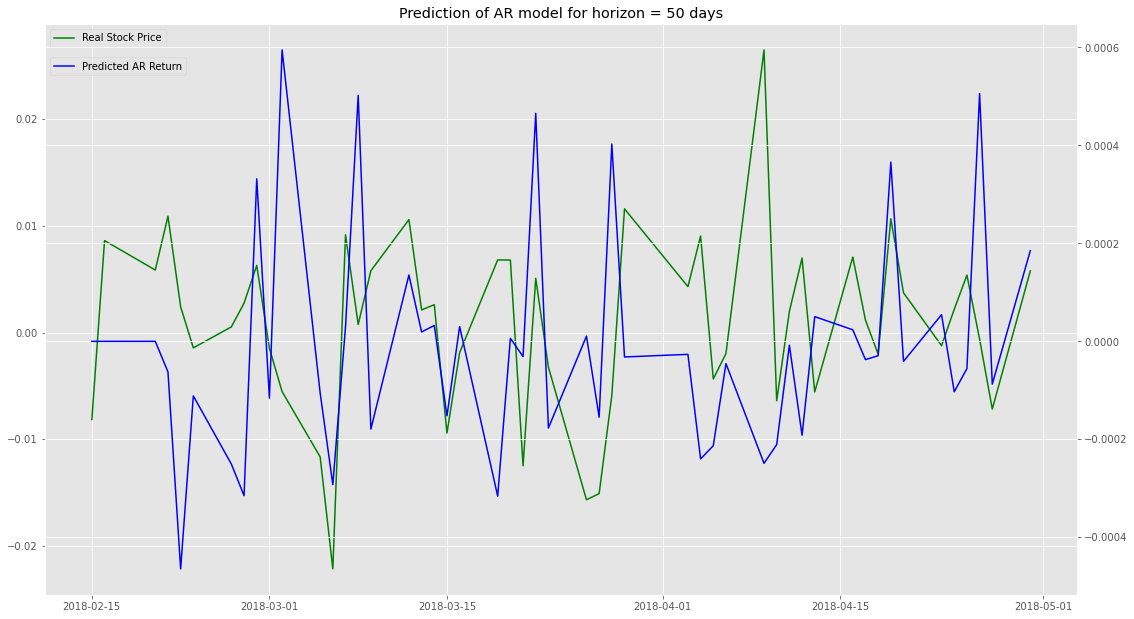

In [31]:
#Test horizon = 50 & comparaison graphique 
horizon = 50
resultat_MA_S50 = prediction_MA_3(vol_MA_S50, horizon)

plt.figure
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.plot(returns.index[T+1:T+1+horizon], testing_data_S50.values[:horizon], color='green', label='Real Stock Price')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(returns.index[T+1:T+1+horizon], resultat_MA_S50, color='blue', label='Predicted AR Return')
ax2.legend(loc=(0.005,0.91))
plt.title('Prediction of AR model for horizon = 50 days')
plt.show()

### III.2.2 - Simulation avec EGARCH(1,1) <a class="anchor" id="chapter3.section2.2"></a>
[Retour Sommaire](#sommaire)

Nous avons également réalisés des simulation à 20 jours avec le modèle EGARCH entrainé.
Nous rappellons ci-dessous l'équation du modèle EGARCH(1,1) utilisé pour réaliser la simulation.

#### Equation du modèle EGARCH(1,1) :
$$r(t) = \mu + \epsilon(t)$$
$$\epsilon(t) = \sigma(t)z(t)$$ 
$$log(\sigma²(t)) = \omega + \alpha(|z(t-1)| - E(|z(t-1)|)) + \nu * z(t-1) + \beta * \log(\sigma²(t-1))$$

<strong>NB :</strong> $ E(|z(t-1)|) = \sqrt(2/\pi) $ sous hypothèse de normalité
; avec z un bruit blanc standard gaussien

#### Liens utiles :
<https://vlab.stern.nyu.edu/docs/volatility/EGARCH> 

In [32]:
#fonction utilisant le modèle EGARCH(1,1) pour réaliser une prédiction sur une période donnée
def prediction_EGARCH(volatility, period):
    z=[np.random.standard_normal()]
    returns=[]
    sigma_t = volatility.iloc[-1]
    for i in range(period):
        sigma_forecast = np.sqrt(10**(omega + alpha*(abs(z[-1]) - np.sqrt(2/np.pi))+nu * z[-1]))* sigma_t **beta
        z_t=np.random.standard_normal()
        epsilon_forecast = sigma_forecast * z_t
        r_forecast = nu + epsilon_forecast
        returns.append(r_forecast)
        z.append(z_t)
        sigma_t= sigma_forecast
    return returns

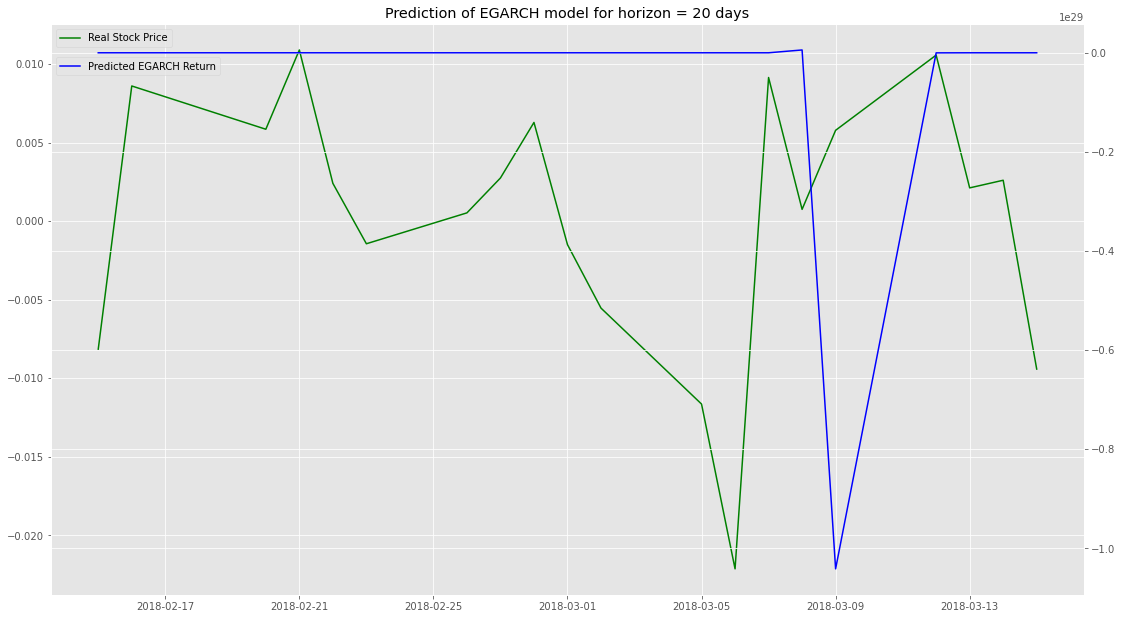

In [33]:
#Test horizon = 20 & comparaison graphique 
horizon = 20
resultat_EGARCH = prediction_EGARCH(vol_egarch_S50, horizon)


plt.figure
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.plot(returns.index[T+1:T+1+horizon], testing_data_S50.values[:horizon], color='green', label='Real Stock Price')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(returns.index[T+1:T+1+horizon], resultat_EGARCH, color='blue', label='Predicted EGARCH Return')
ax2.legend(loc=(0.005,0.91))
plt.title('Prediction of EGARCH model for horizon = 20 days')
plt.show()

Les résultats ne semblent pas concluant avec ce modèle, il ne peut pas être utilisé pour la suite.

### III.2.3 - Simulation avec GARCH(1,1) <a class="anchor" id="chapter3.section2.3"></a>
[Retour Sommaire](#sommaire)

#### Equation du modèle GARCH(1,1) :
$$r(t) = \mu + \epsilon(t)$$
$$\epsilon(t) = \sigma(t)z(t)$$ 
$$\sigma²(t) = \omega + \alpha * \epsilon²(t-1) + \beta * \epsilon²(t-1)$$
avec z un bruit blanc



In [34]:
#fonction utilisant le modèle GARCH(1,1) pour réaliser une prédiction sur une période donnée
def prediction_GARCH(volatility, period):
    returns=[]
    epsilon_t = 0
    sigma_t = volatility.iloc[-1]
    for i in range(period):
        sigma_forecast = np.sqrt(omega + alpha*epsilon_t **2 + beta*sigma_t **2)
        z_t=np.random.standard_normal()
        epsilon_forecast = sigma_forecast * z_t
        r_forecast = nu + epsilon_forecast
        returns.append(r_forecast)
        sigma_t= sigma_forecast
        epsilon_t = epsilon_forecast
    return returns

<ipython-input-34-59c030a583e7>:7: RuntimeWarning: invalid value encountered in sqrt
  sigma_forecast = np.sqrt(omega + alpha*epsilon_t **2 + beta*sigma_t **2)


Date
2007-04-03    0.007851
2007-04-04    0.008700
2007-04-05    0.008493
2007-04-10    0.008264
2007-04-11    0.008299
                ...   
2020-11-02    0.015846
2020-11-03    0.016304
2020-11-04    0.017412
2020-11-05    0.017586
2020-11-06    0.017447
Name: cond_vol, Length: 3338, dtype: float64


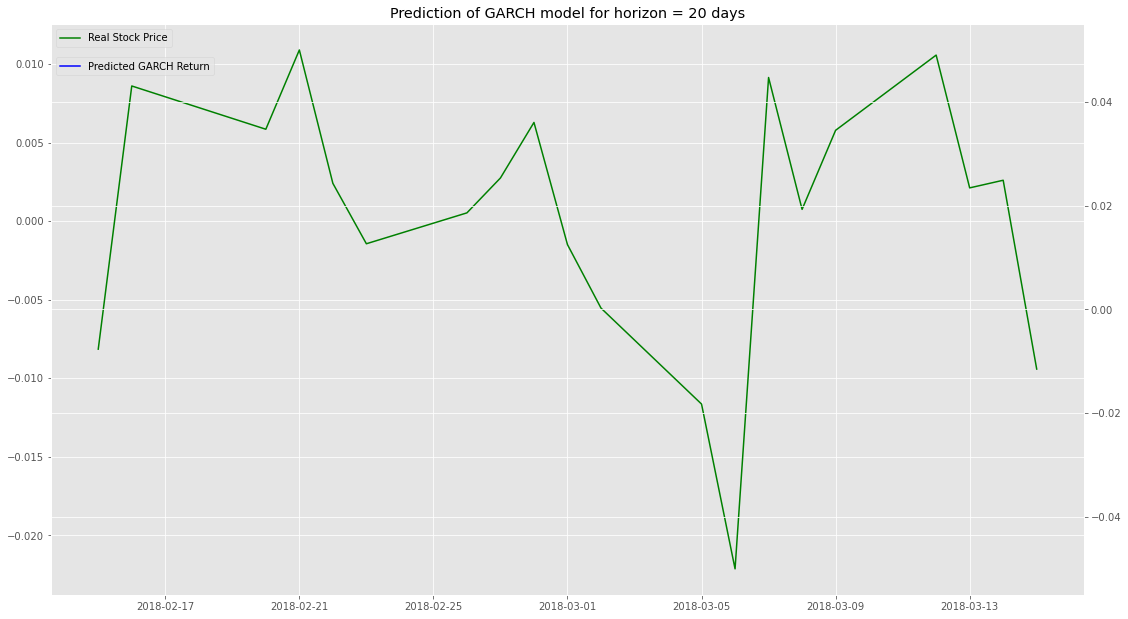

In [35]:
#Test horizon = 20 & comparaison graphique 
horizon = 20
resultat_GARCH = prediction_GARCH(vol_garch_S50, horizon)
print(vol_garch_S50)


plt.figure
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.plot(returns.index[T+1:T+1+horizon], testing_data_S50.values[:horizon], color='green', label='Real Stock Price')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(returns.index[T+1:T+1+horizon], resultat_GARCH, color='blue', label='Predicted GARCH Return')
ax2.legend(loc=(0.005,0.91))
plt.title('Prediction of GARCH model for horizon = 20 days')
plt.show()

<ipython-input-34-59c030a583e7>:7: RuntimeWarning: invalid value encountered in sqrt
  sigma_forecast = np.sqrt(omega + alpha*epsilon_t **2 + beta*sigma_t **2)


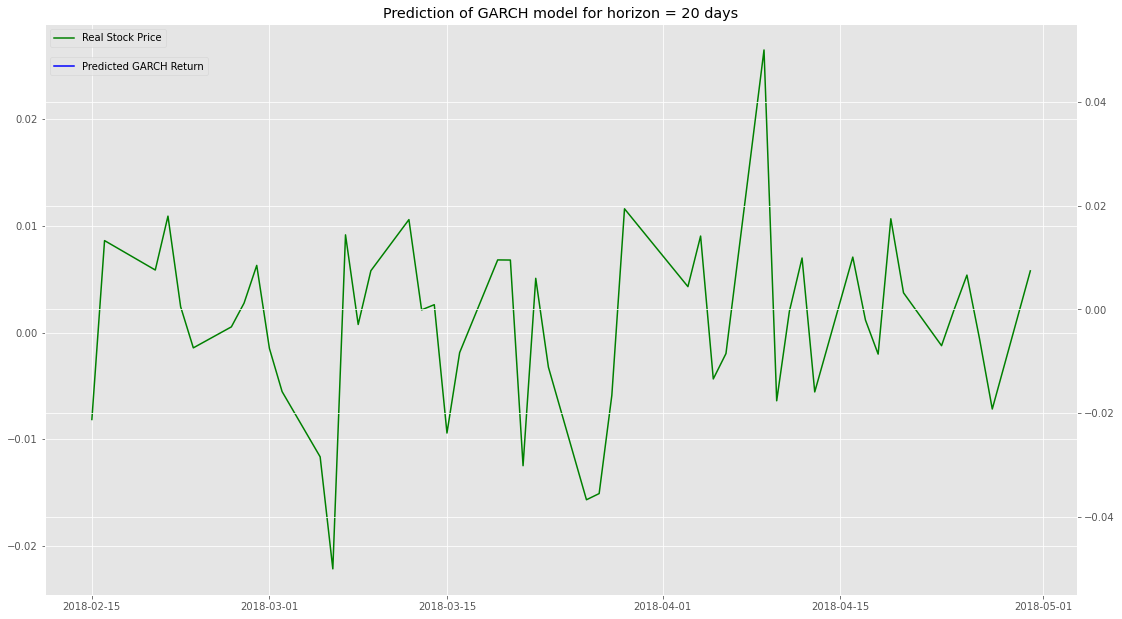

In [36]:
#Test horizon = 50
horizon = 50
resultat_GARCH = prediction_GARCH(vol_garch_S50, horizon)


plt.figure
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax1.plot(returns.index[T+1:T+1+horizon], testing_data_S50.values[:horizon], color='green', label='Real Stock Price')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(returns.index[T+1:T+1+horizon], resultat_GARCH, color='blue', label='Predicted GARCH Return')
ax2.legend(loc=(0.005,0.91))
plt.title('Prediction of GARCH model for horizon = 20 days')
plt.show()

Dans un prochain chapitre, nous reviendrons sur ces prédictions et nous réaliserons une comparaison plus poussée, notamment par rapport aux valeurs réelles, grâce à différentes mesures. Nous comparerons aussi leur performance par rapport au modèle que nous allons décrire dans le prochain chapitre, le boostrapping.

## IV- Bootstrapping & 1ère analyse <a class="anchor" id="chapter4"></a>

[Retour Sommaire](#sommaire)

#### IV.1 - Bootstrapping <a class="anchor" id="chapter4.section1"></a>

On réalise un bootstrapping sur notre <strong> returns du STOXX50 </strong>. Nous générons pour cela 1000 scénarios issus du réechantillonage de notre Training set (par la suite, nous réaliserons plutôt 5000 scénarios à minima).

In [37]:
#On effectue le Bootstrap sur les returns
bootstrapping_S50 = (1+pd.DataFrame([random.choices(list(
    training(returns_S50).values), k=len(SP500.index)-T) for i in 
    range(1000)])).T.shift(1).fillna(1).cumprod()

#Le cumprod() renvoie le produit cumulatif des returns, ce qui permet de directement visualiser le cours de l'action, voir le lien ce dessous
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cumprod.html

bootstrapping_S50.index = testing(returns_S50).index


On peut ensuite visualiser l'ensemble de notre nuage de scénarios sur un graphique :

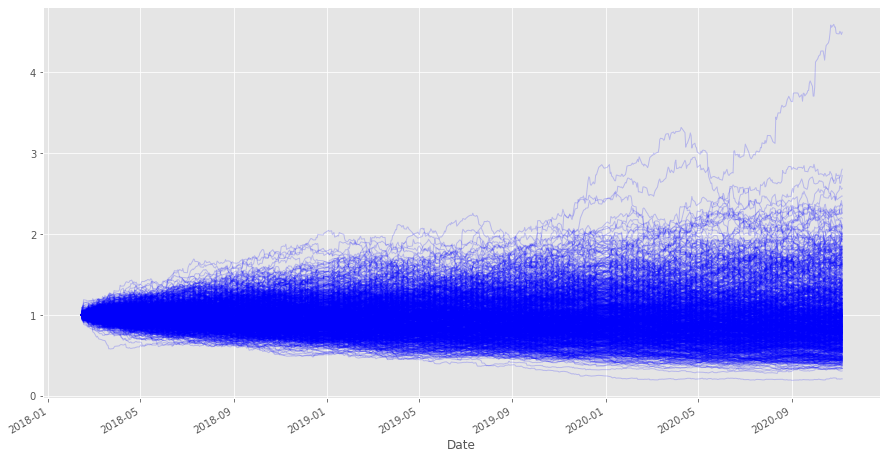

In [38]:
bootstrapping_S50.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2, color='b')

#### IV.2 - 1ère analyse <a class="anchor" id="chapter4.section2"></a>

In [39]:
#On calcul le pourcentage de variation entre t et t-1 pour tous les scénarii générés
r_bootstrapping = bootstrapping_S50.pct_change().dropna()

#On passe au logarithme pour obtenir des rendements pour tous les scénarii
returns_bootstrapping = np.log(1 + r_bootstrapping)

#On passe à la moyenne à chaque instant t de tous les scénarios générés
mean_returns_bootstrapping = returns_bootstrapping.mean()

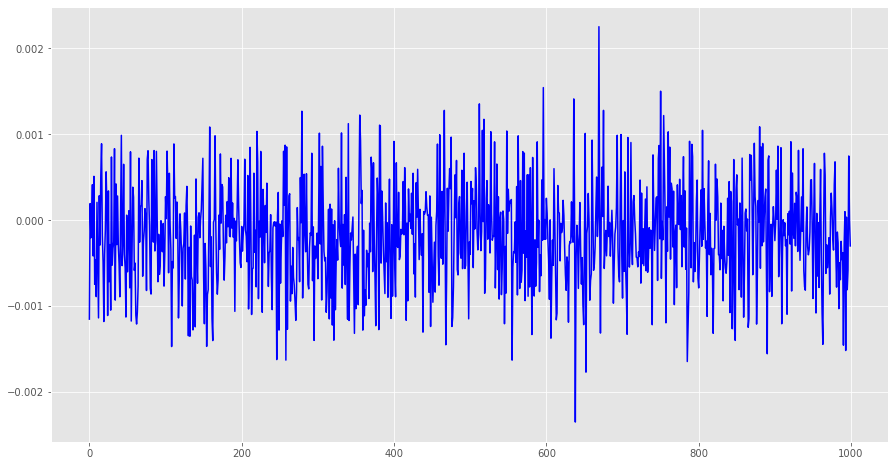

In [40]:
mean_returns_bootstrapping.plot(figsize=(15,8), legend=False,color='b')

On observe que la moyenne est globalement constante. Par la suite, on utilisera la moyenne des rendements (normés) sans logarithme.

On calcule ensuite sur l'ensemble de nos scénarios générés par bootstrapping : 

- <strong>le quantile à 5% et 95% </strong>
- <strong>le quantile à 95% </strong>
- <strong>la moyenne </strong>

Puis on affiche le graphique comprenant ces trois mesures.

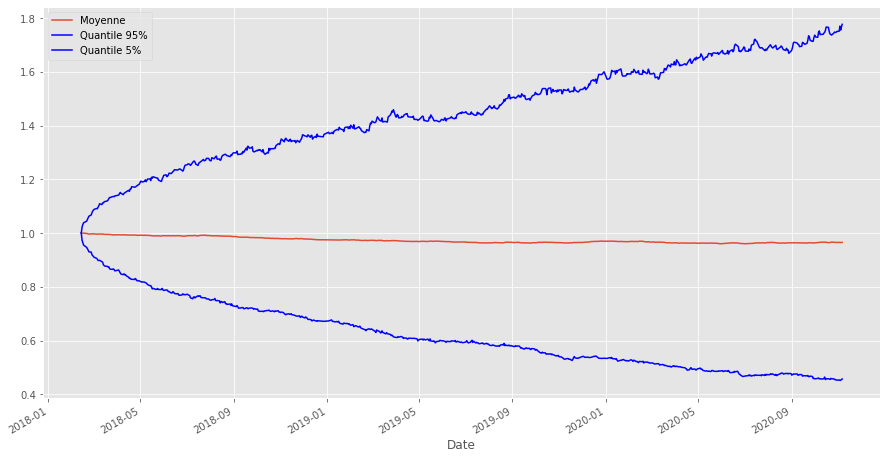

In [41]:
#On peut donc afficher les quantiles et la Moyenne de nos prédictions
Valeur_quantile = 0.95
Quantile_min = bootstrapping_S50.quantile(1-Valeur_quantile,1)
Quantile_max = bootstrapping_S50.quantile(Valeur_quantile,1)
Moyenne = bootstrapping_S50.mean(1)

Moyenne.plot(label='Moyenne',figsize=(15,8))
Quantile_min.plot(label='Quantile 95%',color='b')
Quantile_max.plot(label='Quantile 5%',color='b')
plt.legend()

#### IV.3 - Comparaison avec les valeurs réelles <a class="anchor" id="chapter4.section3"></a>

Nous voulons maintenant comparer nos simulations avec les valeurs réelles de notre portfolio.
Pour cela, nous réalisons tout d'abord un dataframe contenant : 

- Les valeurs réelles
- La moyenne des scénarios simulés
- Le quantile à 5% des scénarios simulés
- Le quantile à 95% des scénarios simulés


In [42]:
# NB : si on veut utiliser un portfolio (cf. ci-dessous)
#portfolio = (data.dropna().mean(axis=1) + 1).cumprod()


prediction = pd.DataFrame({'Testing Set' : list(SP500['SP500'][T:]), 'Moyenne Boostrap' : list(Moyenne),'Quantile 5%' : list(Quantile_min),'Quantile 95%':list(Quantile_max)}, index=testing(returns_S50).index)
prediction = prediction/prediction.iloc[0, :]

Nous représentons le tout dans le graphique ci-dessous : 

In [43]:
temps=list(range(0,len(prediction.index)))
fig = go.Figure()
fig.add_trace(go.Scatter(x=temps, y=list(Moyenne), name="Moyenne Boostrap",
                        line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=temps, y=prediction.iloc[:,0], name="Testing Set",
                        line_color='royalblue'))
fig.add_trace(go.Scatter(x=temps, y=list(Quantile_min), name="Quantile 5%",
                        line_color='dimgray'))
fig.add_trace(go.Scatter(x=temps, y=list(Quantile_max), name="Quantile 95%",
                        line_color='dimgray'))
fig.update_layout(title_text='portfolio',xaxis_rangeslider_visible=True)
fig.show()

## V - Fonction Prediction_Boostrapping <a class="anchor" id="chapter5"></a>

[Retour Sommaire](#sommaire)

Nous avons voulu "automatiser" l'ensemble des actions réalisées précédement au sein d'une seule et unique fonction. Cette fonction prend pour paramètres <strong> un set de données </strong> au format DataFrame et le <strong> nombre de scenario </strong> générés par boostrapping.
Ci-dessous la fonction : 

In [44]:
def prediction_bootstrap (data,nb_simulations):
    #départ à 1
    data = data/data.iloc[0, :]
    returns = data.pct_change().dropna().mean(axis=1)
    training_returns = training(returns)
    testing_returns = testing(returns)
    returns_bootstrapping = (1+pd.DataFrame([random.choices(list(training_returns.values), k=len(testing_returns)) for i in range(nb_simulations)]).T.shift(1).fillna(0)).cumprod()
    returns_bootstrapping.index = testing_returns.index
    Valeur_quantile = 0.95
    #Création des courbes de prédictions
    Quantile_min = returns_bootstrapping.quantile(1-Valeur_quantile,1)
    Quantile_max = returns_bootstrapping.quantile(Valeur_quantile,1)
    Moyenne = returns_bootstrapping.mean(1)
    plt.subplot(211)
    Moyenne.plot(label='Moyenne Boostrap',figsize=(15,8))
    Quantile_min.plot(label='Quantile 95%',color='b')
    Quantile_max.plot(label='Quantile 5%',color='b')
    plt.legend()
    plt.title('Courbes de prédictions')
    data.plot(label='Testing Set',color ='black')
    (Moyenne*float(training(data).iloc[-1])).plot(label='Moyenne Boostrap',figsize=(15,8),color='r')
    (Quantile_min*float(training(data).iloc[-1])).plot(label='Quantile 95%',color='b')
    (Quantile_max*float(training(data).iloc[-1])).plot(label='Quantile 5%',color='b')
    plt.legend()
    plt.title('Courbes d évolution')
   

Nous pouvons maintenant effectuer un test de cette fonction. On constate que les résultats sont équivalents à ceux obtenus dans la partie 3.

En outre, cette fonction permet aussi d'obtenir une visualisation globale de l'évolution du portefeuille, en superposant la partie de training, les différentes simulations (Q5% Q95% et moyenne) ainsi que la valeur du testing set (correspondant au réel).

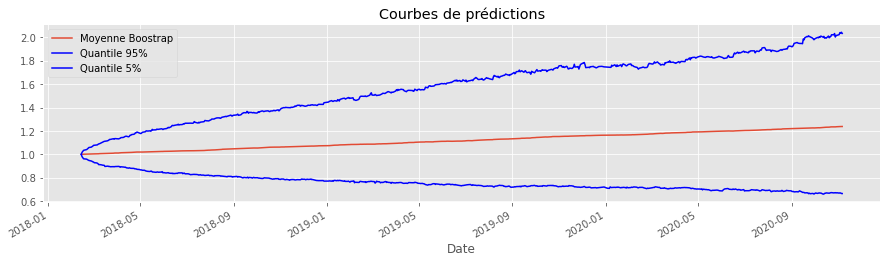

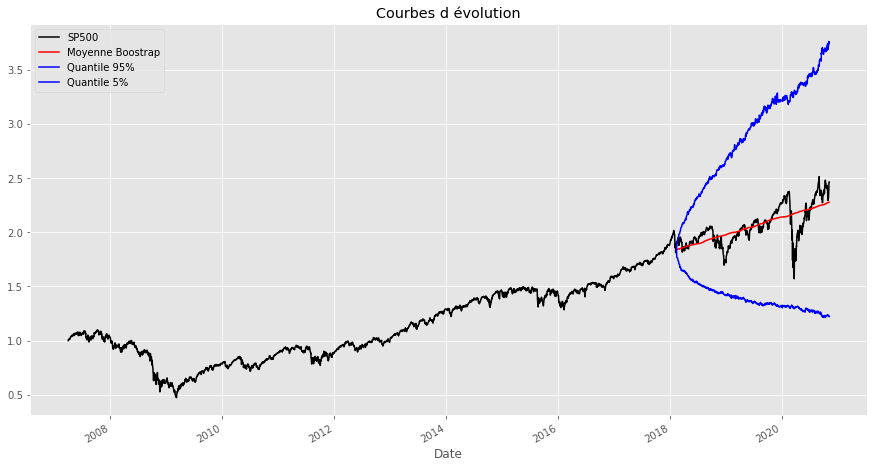

In [45]:
prediction_bootstrap(pd.DataFrame(SP500['SP500']),1000)

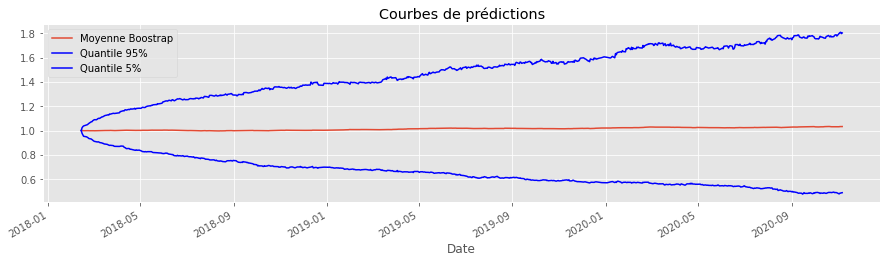

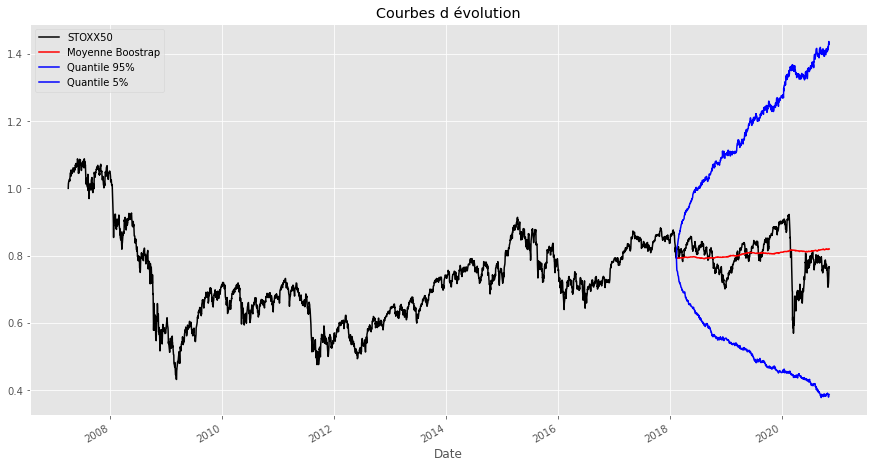

In [288]:
prediction_bootstrap(pd.DataFrame(STOXX50['STOXX50']),1000)

## VI - Fonction de performance <a class="anchor" id="chapter6"></a>

[Retour Sommaire](#sommaire)

Nous allons maintenant comparer de façon statistique les performances des scénarios générés. Pour cela, nous avons réalisé une fonction comprenant un certain nombre de mesures permettant de comparer les différents scénarios.

#### VI.1 - Fonctions de mesures <a class="anchor" id="chapter6.section1"></a>

Nous avons commencé par définir 3 fonctions simples qui permettent de calculer : 

- la déviation en valeur absolue à la médiane d'une distribution de fonction 
- l'asymétrie d'une distribution de fonction 
- le kurtosis d'une distribution de fonction 

NB: Chacune de ces fonctions est réalisé de telle sorte qu'elles peuvent être appliquées à un dataset comportant un ou plusieurs jeux de distributions.

In [289]:
#This function calculates the absolute median deviation of a distribution function.
def Median_Abs_dev(data):    
    mads =[]
    for col in data.columns:
        series = data[col]
        mads.append(series.mad())
    return(mads)

In [290]:
#This function calculates the skewness value of a distribution function.
def skewness(data):    
    skews =[]
    for col in data.columns:
        series = data[col]
        skews.append(series.skew())
    return(skews)

In [291]:
#This function calculates the kurtosis value of a distribution function
def kurtosis(data):
    kurtos =[]
    for col in data.columns:
        series = data[col]
        kurtos.append(series.kurt())
    return(kurtos)

Nous avons ensuite choisi 3 mesures permettant de calculer la distance entre deux distributions de fonctions : 

- la distance d'Hellinger
- la distance de Kullback-Leiber
- la distance de Bhattacharyya

NB: Chacune de ces fonctions est réalisée de telle sorte qu'elles peuvent être appliquées à un dataset comportant un ou plusieurs jeux de distributions.

<strong><u> Z-test  - Comparaison de la moyenne des distributions </strong></u> 

$$ Z = \frac{\bar{X} - \mu_{0}}{s} $$

où : 
- $Z$ : Z-test
- $\bar{X}$ : moyenne de l'échantillon
- $\mu_{0} $ : espérance
- $s$ : écart-type


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
- https://en.wikipedia.org/wiki/Z-test

In [292]:
#  ! WARNING ! -> This function calculates the Z-Score of one distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
from statsmodels.stats.weightstats import ztest

def Z_score(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> (Student) t-test  - Comparaison de la moyenne des distributions </strong></u> 

$$ t = \frac{m - \mu_{0}}{s/ \sqrt{n}} $$

où : 
- $t$ : t-test
- $m$ : espérance
- $\mu_{0} $ : valeur théorique
- $s$ : écart-type
- $n$ : taille de l'échantillon


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
- https://en.wikipedia.org/wiki/Student%27s_t-test

In [293]:
#  ! WARNING ! -> This function calculates the t-Score of two distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def t_score(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> F-Test  - Comparaison de la variance des distributions </strong></u> 

$$ F = \frac{Explained Variance}{Unexplained Variance} $$

avec :

$$ Explained Variance = \sum_{i = 1}^{K}n_{i} ({\bar {Y}}_{i \cdot} - {\bar {Y}})^{2} / (K - 1) $$
et
$$ Unexplained Variance = \sum_{i = 1}^{K} \sum_{j = 1}^{n_{i}} ({\bar {Y}}_{ij \cdot} - {\bar {Y}}_{i \cdot})^{2} / (N - K) $$

où 
- $ {Y}_{ij} $ est la j-ème observation dans la i-ème sur K groupes
- N : taille globale de l'échantillon 


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
- https://en.wikipedia.org/wiki/F-test

In [294]:
#  ! WARNING ! -> This function calculates the F-test of two distributions
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

from scipy.stats import f_oneway

def F_test(data):
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> Test de rang de Mann-Whitneyu  </strong></u> 

Laisser $X_{1}, \ldots, X_{n}$ être un échantillon i.i.d de X et $Y_{1}, \ldots, Y_{n}$ un échantillon i.i.d de Y avec X et Y indépendants l'un de l'autre. 

La statistique U de Mann-Whitney correspondante est définie comme suit:

$$ U = \sum_{i = 1}^{n} \sum_{j = 1}^{m} S(X_{i}, Y_{j})  $$

avec

$
  S (X, Y) = \left\{
          \begin{array}{ll}
            1 & \qquad \mathrm{si}\quad Y < X \\
            \frac{1}{2} & \qquad \mathrm{si}\quad Y = X \\
            0 & \qquad \mathrm{si}\quad Y > X \\
          \end{array}
        \right.
$


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
- https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

In [295]:
#  ! WARNING ! -> This function calculates the Mann_Whitneyu Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Mann_Whitneyu(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> Test de rang de Wilcoxon  </strong></u> 

Laisser $X_{1}, \ldots, X_{n}$ être un échantillon i.i.d de X et $Y_{1}, \ldots, Y_{n}$ un échantillon i.i.d de Y avec X et Y indépendants l'un de l'autre. 

Le test statistique de Wilcoxon est défini comme suit:

$$ W = \sum_{i = 1}^{N_{r}} [sgn(x_{2,i} - x_{1,i}) * R_{i}]$$

avec
- $W$ : test statistique 
- $N_{r}$ : taille de l'échantillon
- $sng$ : signe de la function
- $x_{2,i} - x_{1,i}$ : paires classées correspondantes des deux distributions
- $R_{i}$ : rang i

Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
- https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test

In [296]:
#  ! WARNING ! -> This function calculates the Wilcoxon Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Wilcoxon(data) :
    stat_val = []
    res_p_val = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
        else:
            series = data[col]
            stat_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[1])
    return (stat_val, res_p_val)

<strong><u> Distance de Wasserstein </strong></u> 

La première distance de Wasserstein entre les distributions $u$ et $v$ est:


$$ l_{1}(u,v) =  \inf_{\substack{\pi \in \Gamma(u,v)}} \int_{\mathbb{R}x\mathbb{R}} |x - y|d\pi(x,y)$$

Lien : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html

In [297]:
#  ! WARNING ! -> This function calculates the Hellinger distance between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Wasserstein(data) :
    res = []
    for col in data.columns:
        series = data[col]
        res.append(wasserstein_distance(data['Testing Set'], data[col]))
    return(res)

#### VI.2 - Fonction Describe <a class="anchor" id="chapter6.section2"></a>

Grâce à toutes les fonctions présentées dans la partie précédente, nous avons réalisé une fonction globale qui, pour un unique dataset en entrée (au format DataFrame), retourne un tableau comparatif comportant les éléments suivants : 

- Espérance & Variance 
- Min / Q25% / Médiane / Q75% / Max
- Déviation de la médiane en valeure absolue
- Asymétrie & Kurtosis
- <strong> Z-test </strong> & <strong>t-test</strong> (pour la comparaison de la moyenne)
- <strong>F-test </strong>(pour la comparaison de la variance)
- <strong>Test de rang de Mann-Whitneyu </strong> & <strong> Test de Wilcoxon</strong> (pour comparer le ranking de deux distributions)
- <strong> Mesure de Wasserstein </strong> (pour comparer la distance entre deux distributions)


<u> NB:</u> Cette fonction est réalisée de telle sorte qu'elle peut être appliqué à un dataset comportant un ou plusieurs jeux de distributions. Dans le cas d'un dataset multiple, les distance citées précédement seront toujours calculées en fonction de la première colonne de ce dataset.

<strong><u> Conséquence: </strong></u>  Il faut impérativement placer les valeurs réelles dans la première colonne de notre DataFrame, afin de pouvoir comparer chaque simulation avec les valeurs réelles, et ainsi comparer la performance de chacunes de nos simulations.

In [298]:
def describe(data):
    res = data.describe()             #Create the table with Mean / std / Min / 1st quartile / Meadian /1 3rd quartile / Max
    res.loc['Median Absolute Deviation'] = Median_Abs_dev(data) #Add MAD measurement to the recap table
    res.loc['skew'] = skewness(data)                                   #Add skew measurement to the recap table
    res.loc['kurtosis'] = kurtosis(data)                               #Add kurtosis measurement to the recap table
    
    # Marche uniquement si notre Dataframe à 2 indices ou plus
    if len(data.columns) > 1 : 
        res.loc['Wasserstein Distance'] = Wasserstein(data)
        res.loc['Wilcoxon Test'] = Wilcoxon(data)[0]
        res.loc['Wilcoxon p-value'] = Wilcoxon(data)[1]
        res.loc['Mann-Whitneyu Test'] = Mann_Whitneyu(data)[0]
        res.loc['Mann-Whitneyu p-value'] = Mann_Whitneyu(data)[1]
        res.loc['F_test'] = F_test(data)[0]
        res.loc['F_test p-value'] = F_test(data)[1]
        res.loc['t_test'] = t_score(data)[0]
        res.loc['t_test p-value'] = t_score(data)[1] 
        res.loc['Z_test'] = Z_score(data)[0]
        res.loc['Z_test p-value'] = Z_score(data)[1]
    return res

Nous testons notre fonction de performance sur le dataframe de prédictions, qui comporte : 

- Nos données réelles
- La moyenne de nos scénarii générés
- Le quantile 5% de nos scénarii générés
- Le quantile 95% de nos scénarii générés

In [380]:
print(prediction)
describe(prediction)

            Real Data  Simulated Data  Quantile 5%  Quantile 95%
Date                                                            
2018-02-13   1.000000        1.000000     1.000000      1.000000
2018-02-14   1.013402        0.999569     0.981987      1.015596
2018-02-15   1.025633        0.999205     0.976185      1.021515
2018-02-16   1.026016        0.999117     0.969682      1.025781
2018-02-20   1.020023        0.998494     0.964074      1.031366
...               ...             ...          ...           ...
2020-11-02   1.243077        0.932361     0.586813      1.407784
2020-11-03   1.265203        0.932778     0.590460      1.403272
2020-11-04   1.293097        0.933079     0.592792      1.398809
2020-11-05   1.318261        0.932717     0.591037      1.395301
2020-11-06   1.317882        0.932475     0.588725      1.398084

[668 rows x 4 columns]


KeyError: 'Testing Set'

On observe évidemment ici que la moyenne est la simulation qui a les paramètres les plus proches de ceux de la distribution du testing set. En revanche, on peut remarquer que le quantile 5% représente mieux la distribution réelle que le quantile à 95%.

NB : On peut voir que la distance de Bhattacharyya ne fonctionne pas pour le quantile 5% => racine de nombre négatif, à modifier.

Ci-dessous, nous avons tracé les distributions des valeurs réelles et celle de la moyenne des scénarios générés.

In [ ]:
prediction[['Testing Set','Moyenne Boostrap', 'Quantile 5%', 'Quantile 95%']].plot.density(figsize=(15,8))

On remarque en effet que la distribution du quantile à 5% est plus ressemblante à celle de la distribution réelle.

#### VI.3 - Comparaison des prévisions par boostrapping et des modèles AR(1), GARCH(1,1) et AR(1)-GARCH(1,1) <a class="anchor" id="chapter6.section3"></a>
[Retour Sommaire](#sommaire)

## VII - Filtred Historical Simulation <a class="anchor" id="chapter7"></a>

[Retour Sommaire](#sommaire)

<u><strong> Etape 1 :</strong> Trouver le meilleur modèle de volatilité conditionnel (GARCH) pour le rendement à modéliser </u>

Pour rappel, nous avons défini une fonction <i> best_param_garch </i> en <strong> III.1.1 </strong>. Nous allons nous en servir afin de trouver le meilleur modéle GARCH

In [312]:
# GARCH Model (with constant mean)

[p,q] = best_param_garch(training(returns_S50),5,5)
print("Les meilleurs paramètres sont p="+str(p)+" et q="+str(q))


Les meilleurs paramètres sont p=1 et q=1


<u><strong> Etape 2 : </strong> Standardisation des rendements </u>

In [313]:
#Modèle GARCH(1,1)
modele_garch=arch_model(training(returns_S50), mean='Zero', vol='GARCH', p=p, o=0, q=q, dist='StudentsT',rescale=True)

#estimation des paramètres
modele_garch_fit = modele_garch.fit(update_freq=5,disp='off')

#résidus du modèle
residus_garch = modele_garch_fit.resid

#volatilité du modèle GARCH(1,1)
vol_garch = modele_garch_fit.conditional_volatility

In [314]:
print(residus_garch)
print(training(returns_S50))
# toujours ce facteur 100

Date
2007-04-03    1.345469
2007-04-04    0.365069
2007-04-05    0.227576
2007-04-10    0.698245
2007-04-11   -0.192445
                ...   
2018-02-05   -1.271359
2018-02-06   -2.439862
2018-02-07    1.740335
2018-02-08   -2.260694
2018-02-09   -1.530922
Name: resid, Length: 2669, dtype: float64
Date
2007-04-03    0.013455
2007-04-04    0.003651
2007-04-05    0.002276
2007-04-10    0.006982
2007-04-11   -0.001924
                ...   
2018-02-05   -0.012714
2018-02-06   -0.024399
2018-02-07    0.017403
2018-02-08   -0.022607
2018-02-09   -0.015309
Name: None, Length: 2669, dtype: float64


Une fois les volatilité obtenues, nous allons les utilisés pour standardiser nos rendements (de notre training set) : 

<u> Standardisation des rendements : </u> 

$$ Std\_Return = \frac{Data_{Train}}{\sigma}  $$

where :

- $ Var(Data) = \sigma^2 $

In [366]:
# Standardisation des returns S50
data_S50 = pd.DataFrame(index = training(returns_S50).index)
data_S50['Standardized returns'] = training(returns_S50) / vol_garch
data_S50 = pd.DataFrame(data_S50.to_records())
print(training(returns_S50))
print(vol_garch)
# On affiche le dataframe obtenu
data_S50

Date
2007-04-03    0.013455
2007-04-04    0.003651
2007-04-05    0.002276
2007-04-10    0.006982
2007-04-11   -0.001924
                ...   
2018-02-05   -0.012714
2018-02-06   -0.024399
2018-02-07    0.017403
2018-02-08   -0.022607
2018-02-09   -0.015309
Name: None, Length: 2669, dtype: float64
Date
2007-04-03    0.772473
2007-04-04    0.851568
2007-04-05    0.829408
2007-04-10    0.804245
2007-04-11    0.805919
                ...   
2018-02-05    0.861884
2018-02-06    0.916227
2018-02-07    1.150317
2018-02-08    1.221883
2018-02-09    1.355258
Name: cond_vol, Length: 2669, dtype: float64


Date  Standardized returns
0    2007-04-03              0.017418
1    2007-04-04              0.004287
2    2007-04-05              0.002744
3    2007-04-10              0.008682
4    2007-04-11             -0.002388
...         ...                   ...
2664 2018-02-05             -0.014751
2665 2018-02-06             -0.026629
2666 2018-02-07              0.015129
2667 2018-02-08             -0.018502
2668 2018-02-09             -0.011296

[2669 rows x 2 columns]

<u><strong>Etape 3 :</strong> Bootstrapping à partir des rendements standardisés </u>

In [352]:
# On réalise un boostrapping (cf. paragraphe concerné) avec nos rendements standardisés

bootstrapping_FHS = (1+pd.DataFrame([random.choices(list(
    data_S50['Standardized returns'].values), k=len(STOXX50.index)-T) for i in 
    range(1000)]).T.shift(1).fillna(0)).cumprod()

# On modifie l'indec de notre datafram
bootstrapping_FHS.index = testing(returns_S50).index

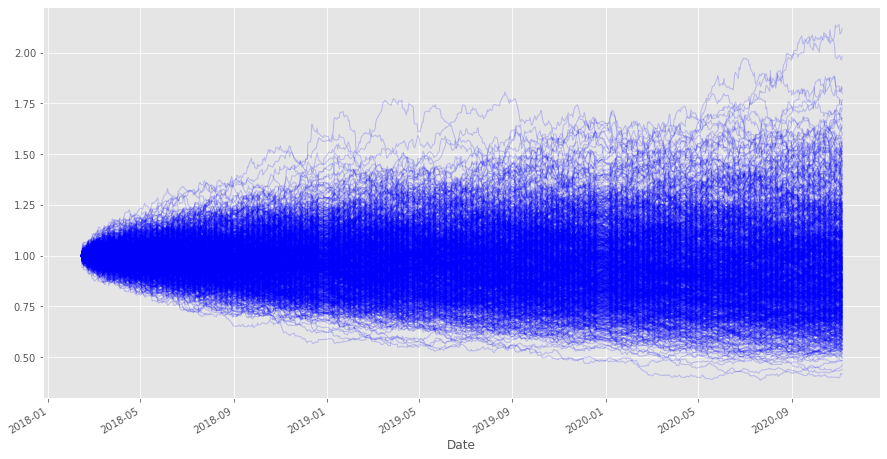

In [353]:
# On affiche l'ensemble des scénarios obtenu par le procédé de boostrapping
bootstrapping_FHS.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2, color='b')

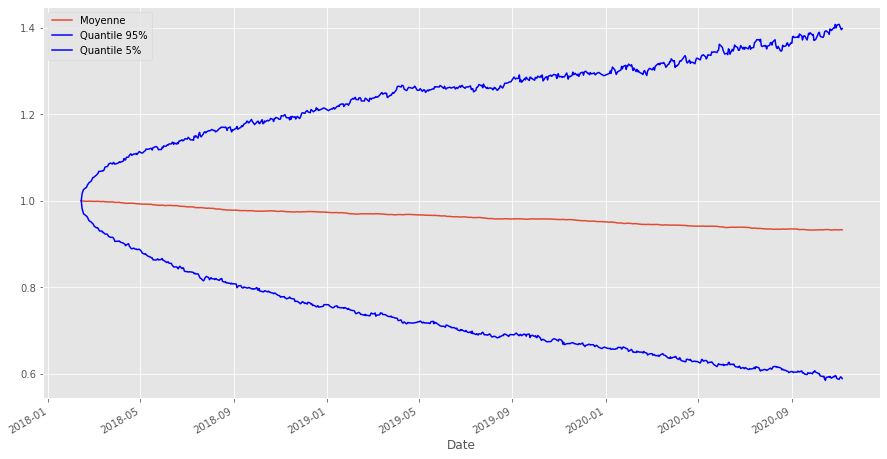

In [354]:
#Calcul des valeurs
Valeur_quantile = 0.95
Quantile_min = bootstrapping_FHS.quantile(1-Valeur_quantile,1)
Quantile_max = bootstrapping_FHS.quantile(Valeur_quantile,1)
Moyenne = bootstrapping_FHS.mean(1)

#Affichage du graphique 
Moyenne.plot(label='Moyenne',figsize=(15,8))
Quantile_min.plot(label='Quantile 95%',color='b')
Quantile_max.plot(label='Quantile 5%',color='b')
plt.legend()

In [355]:
prediction=pd.DataFrame({'Real Data' : list(SP500['SP500'][T:]), 'Simulated Data' : list(Moyenne),'Quantile 5%' : list(Quantile_min),'Quantile 95%':list(Quantile_max)}, index=testing(returns_S50).index)
prediction = prediction/prediction.iloc[0, :]

In [356]:
temps=list(range(0,len(prediction.index)))
fig = go.Figure()
fig.add_trace(go.Scatter(x=temps, y=list(Moyenne), name="Simulated Data (moyenne)",
                        line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=temps, y=prediction.iloc[:,0], name="Real Data",
                        line_color='royalblue'))
fig.add_trace(go.Scatter(x=temps, y=list(Quantile_min), name="Quantile",
                        line_color='dimgray'))
fig.add_trace(go.Scatter(x=temps, y=list(Quantile_max), name="Quantile",
                        line_color='dimgray'))
fig.update_layout(title_text='portfolio',xaxis_rangeslider_visible=True)
fig.show()

### Autre méthode : calcul de la volatilité sur une fenêtre glissante 

Le calcul du meilleur modèle GARCH est un processus qui prend beaucoup de temps uniquement pour calculer une volatilité.
Nous proposons d'adopter une méthode qui permettra de gagner en rapidité d'execution sans trop perdre en précision de calcul.

Pour cela, nous allons calculer directement la volatilité historique (= écart-type, i.e la racine carrée de la variance de notre jeux de données) sur une fenêtre glissante de données. Nous avons choisi de prendre un échantillon de 20 valeurs, afin qu'il soit suffisament représentatif.

Le détail est réalisé ci-dessous : 

In [ ]:
# data = dataframe avec un index
# len_fenetre = entier strictement positif & inférieur à len(data)
# pour les premières valeurs, on reprend celles renvoyées par le modèle garch(1,1) fitté sur toute les data

def vol_histo_glissant(data, len_fenetre):
    # Initialisation de notre retour
    res = pd.DataFrame(index = data.index)   
    res['Volatility'] = 0    
        
    # On commence par remplir notre dataframe en calculant pour les "len_fenetre" premières volatilité à l'aide du modèle GARCH(1,1)
    for i in range(len_fenetre):
        res.iloc[i,0] = vol_garch[i]
        
        
    # Calcul de la volatilité "manuellement"
    for i in range(len_fenetre, len(data)):
        #calc_vol = np.sqrt(data[i-len_fenetre:i].var())
        calc_vol = 100*data[i-len_fenetre:i].std(axis=0)
        res.iloc[i,0] = calc_vol

    
    # Mise en forme de notre sortie
    res = pd.DataFrame(res.to_records())
    
    return(res)

In [ ]:
# On lance notre fonction 
vols_historique = vol_histo_glissant(training(returns_S50), 20)

In [ ]:
vols_historique

In [ ]:
# à revoir

# On peut comparer les valeurs obtenus avec les valeurs calculées grâce au modèle GARCH 
vols_historique['Compare'] = 0
vols_historique['Pct Compare'] = 0
for i in range(len(vols_historique.index)):
    vols_historique.iloc[i,2] = vol_garch[i] - vols_historique.iloc[i,1]
    vols_historique.iloc[i,3] = (1-vol_garch[i] / vols_historique.iloc[i,1])*100

vols_historique

# Moyenne des pourcentages de différences entre la méthode GARCH et la méthode manuelle
#vols_historique['Pct Compare'][20:].mean()

On observe que la méthode "manuelle" diminue la volatilité de près de 20% (-14.7%) par rapport à la méthode utilisant un modèle GARCH adapté à chaque jeu de données.

En augmentant la taille des échantillons de données, on peut minimiser cette "erreur". On obtient ainsi -15% avec 40 valeurs, -13% avec 100 valeurs.

Nous allons continué nos calculs avec une fenêtre de 20 valeurs pour notre calcul de volatilité.

Une fois les volatilité obtenues, nous allons les utilisés pour standardiser nos rendements (de notre training set) : 

<u> Standardisation des rendements : </u> 

$$ Std\_Return = \frac{Data_{Train}}{\sigma}  $$

where :

- $ Var(Data) = \sigma^2 $

In [ ]:
# Standardisation des returns S50
vols_historique['Standardized returns'] = 0
for i in range(len(vols_historique.index)):
    vols_historique.iloc[i,4] = training(returns_S50)[i] / vols_historique.iloc[i,1]

# On affiche le dataframe obtenu
vols_historique

In [ ]:
# On réalise un bootstrapping (cf. paragraphe concerné) avec nos rendements standardisés

data_bootstrapping_histo = (1+pd.DataFrame([random.choices(list(
    vols_historique['Standardized returns'].values), k=len(SP500.index)-T) for i in 
    range(1000)]).T.shift(1).fillna(0)).cumprod()

# On modifie l'indec de notre dataframe
data_bootstrapping_histo.index = testing(returns_S50).index

In [ ]:
# On affiche l'ensemble des scénarios obtenu par le procédé de bootstrapping
data_bootstrapping_histo.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2, color='b')

In [ ]:
#Calcul des valeurs
Valeur_quantile = 0.95
Quantile_min = data_bootstrapping_histo.quantile(1-Valeur_quantile,1)
Quantile_max = data_bootstrapping_histo.quantile(Valeur_quantile,1)
Moyenne = data_bootstrapping_histo.mean(1)

#Affichage du graphique 
Moyenne.plot(label='Moyenne',figsize=(15,8))
Quantile_min.plot(label='Quantile 95%',color='b')
Quantile_max.plot(label='Quantile 5%',color='b')
plt.legend()

In [ ]:
prediction = pd.DataFrame({'Real Data' : list(SP500['SP500'][T:]), 'Simulated Data' : list(Moyenne),'Quantile 5%' : list(Quantile_min),'Quantile 95%':list(Quantile_max)}, index=testing(returns_S50).index)
prediction = prediction/prediction.iloc[0, :]

In [ ]:
temps=list(range(0,len(prediction.index)))
fig = go.Figure()
fig.add_trace(go.Scatter(x=temps, y=list(Moyenne), name="Simulated Data (moyenne)",
                        line_color='deepskyblue'))
fig.add_trace(go.Scatter(x=temps, y=prediction.iloc[:,0], name="Real Data",
                        line_color='royalblue'))
fig.add_trace(go.Scatter(x=temps, y=list(Quantile_min), name="Quantile",
                        line_color='dimgray'))
fig.add_trace(go.Scatter(x=temps, y=list(Quantile_max), name="Quantile",
                        line_color='dimgray'))
fig.update_layout(title_text='portfolio',xaxis_rangeslider_visible=True)
fig.show()

In [133]:
class Series:
    
    def __init__(self, name, values, type_serie):
        self.name = name # nom de la série
        self.values = values # dataframe des valeurs
        self.type_serie = type_serie
    
    # Fonction qui plot les données
    def visualization(self):
        plt.plot(self.values)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Evolution of ' + self.name)
    
    # Fonction qui plot et retourne le tableau des valeurs des rendements
    def returns(self):
        if self.type_serie == "Action":
            var_pct = self.values.pct_change().dropna()
            ret = np.log(1 + var_pct)
        if self.type_serie == "Taux":
            ret = self.values.diff().dropna()
        plt.plot(ret)
        plt.xlabel('Date')
        plt.ylabel('Return')
        plt.title('Daily Logarithmic Returns for ' + self.name)
        return(ret)
    
    # Fonction qui renvoie la partie "training" du dataset
    def training(self):
        ret = self.returns()
        plt.close()
        T=len(ret.index)
        T=int(np.floor(T*0.8))
        return(ret[0:T-1])
    
    # Fonction qui renvoie la partie "testing" du dataset
    def testing(self):
        ret = self.returns()
        plt.close()
        T=len(ret.index)
        T=int(np.floor(T*0.8))
        return(ret[T:])
    
    # Fonction qui fit et renvoie un modèe Garch optimal pour les rendements de la série
    def garch_modelisation(self):
        ret = self.returns()
        plt.close()
        training_data = self.training()
        testing_data = self.testing()
        [p,q] = best_param_garch(training_data,5,5)
        model = arch_model(training_data, vol='garch', p=p, o=0, q=q, rescale=False)
        fit = model.fit(update_freq=5,disp='off')
        print(fit.summary())
        return(fit)
    
    # Fonction de prédiction paramétrique des returns (à revoir et à compléter)
    def parametric_modelisation(self):
        ret = self.returns()
        plt.close()
        training_data=training(ret)
        testing_data=testing(ret)
        plt.plot(training_data,label="training")
        plt.plot(testing_data,label="testing")
        plt.legend()
        [p,q] = best_param_garch(training_data,5,5)
        model = arch_model(ret, vol='Garch', p=p, o=0, q=q, rescale=True)
        fit = model.fit(update_freq=5, disp = 'off')
        h = len(testing_data)
        forecasts = fit.forecast(horizon = h)
        print(forecasts)
        
    # Fonction qui utilise la méthode HS (simple bootstrap) pour prédire les rendements/prix
    def historical_simulation(self,nb_paths):
        ret = self.returns()
        plt.close()
        training_data = self.training()
        testing_data = self.testing()
        départ = float(self.values.iloc[int(np.floor(len(ret.index)*0.8))-2])
        bootstrapped_returns = pd.DataFrame([random.choices(list(training_data.iloc[:,0]), k=len(testing_data)) for i in range(nb_paths)]).T
        bootstrapped_returns.index = testing_data.index
        bootstrapped_returns.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Rendements logarithmiques bootstrappés, nombre de chemins = '+str(nb_paths))
        bootstrapped_returns.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_returns.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_returns.mean(1).plot(label='Moyenne',color='r')
        
        data=self.values
        bootstrapped_prices = (1+bootstrapped_returns).shift(1).fillna(départ).cumprod()
        bootstrapped_prices.index = testing_data.index
        bootstrapped_prices.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Scénarios de prix normalisés à 1, nombre de chemins = '+str(nb_paths))
        plt.plot(data,color ='black')
        bootstrapped_prices.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_prices.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_prices.mean(1).plot(label='Moyenne',color='r')
        return(bootstrapped_returns.mean(1))
    
    
    # Fonction qui utilise la méthode FHS (bootstrapping sur rendements standardisés) pour prédire les rendements/prix    
    def filtered_historical_simulation(self,nb_paths):  
        ret = self.returns()
        plt.close()
        training_data = self.training()
        testing_data = self.testing()
        départ = float(self.values.iloc[int(np.floor(len(ret.index)*0.8))-2])
        model = self.garch_modelisation()
        volatility = model.conditional_volatility
        standardized_returns = training_data.iloc[:,0]/volatility # Rendements standardisés bizarres (fonction à revoir)
        
        bootstrapped_returns = pd.DataFrame([random.choices(list(standardized_returns), k=len(testing_data)) for i in range(nb_paths)]).T
        bootstrapped_returns.index = testing_data.index
        bootstrapped_returns.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Rendements standardisés bootstrappés, nombre de chemins = '+str(nb_paths))
        bootstrapped_returns.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_returns.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_returns.mean(1).plot(label='Moyenne',color='r')
        
        data=self.values
        bootstrapped_prices = (1+bootstrapped_returns).shift(1).fillna(départ).cumprod()
        bootstrapped_prices.index = testing_data.index
        bootstrapped_prices.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Scénarios de prix, nombre de chemins = '+str(nb_paths))
        plt.plot(data,color ='black')
        bootstrapped_prices.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_prices.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_prices.mean(1).plot(label='Moyenne',color='r')
        return(bootstrapped_returns.mean(1))
       
    # Fonction qui compare les résultats de nos différentes méthodes (à compléter)
    def describe(self,méthode):
        if méthode=="HS":
            simulated_data=self.historical_simulation(1000)
            plt.close()
        if méthode=="FHS":
            simulated_data=self.filtered_historical_simulation(1000)
            plt.close()
        testing_data = self.testing()
        Data = pd.DataFrame({'Real Data' : list(self.testing().iloc[:,0]), 'Simulated Data' : list(simulated_data)}, index=testing_data.index)
        
        res = Data.describe()             #Create the table with Mean / std / Min / 1st quartile / Meadian /1 3rd quartile / Max
        res.loc['Median Absolute Deviation'] = Median_Abs_dev(Data) #Add MAD measurement to the recap table
        res.loc['skew'] = skewness(Data)                                   #Add skew measurement to the recap table
        res.loc['kurtosis'] = kurtosis(Data)                               #Add kurtosis measurement to the recap table
        
        # Marche uniquement si notre Dataframe à 2 indices ou plus
        #if len(Data.columns) > 1 : 
        #    res.loc['Wasserstein Distance'] = Wasserstein(Data)
        #    res.loc['Wilcoxon Test'] = Wilcoxon(Data)[0]
        #    res.loc['Wilcoxon p-value'] = Wilcoxon(Data)[1]
        #    res.loc['Mann-Whitneyu Test'] = Mann_Whitneyu(Data)[0]
        #    res.loc['Mann-Whitneyu p-value'] = Mann_Whitneyu(Data)[1]
        #    res.loc['F_test'] = F_test(Data)[0]
        #    res.loc['F_test p-value'] = F_test(Data)[1]
        #    res.loc['t_test'] = t_score(Data)[0]
        #    res.loc['t_test p-value'] = t_score(Data)[1] 
        #    res.loc['Z_test'] = Z_score(Data)[0]
        #    res.loc['Z_test p-value'] = Z_score(Data)[1]
        return res

Date
2017-08-31   -0.0080
2017-09-01    0.0104
2017-09-04   -0.0100
2017-09-05    0.0062
2017-09-06    0.0088
               ...  
2020-11-02    0.0006
2020-11-03    0.0040
2020-11-04   -0.0144
2020-11-05   -0.0056
2020-11-06    0.0062
Length: 810, dtype: float64

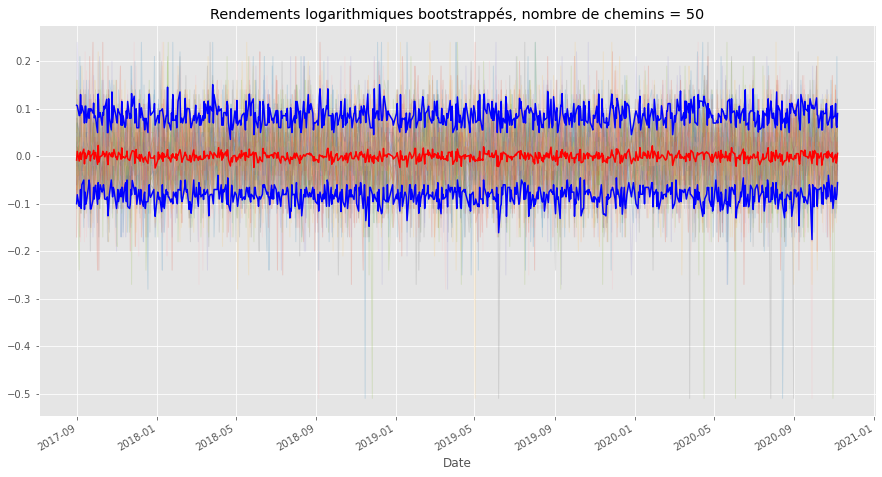

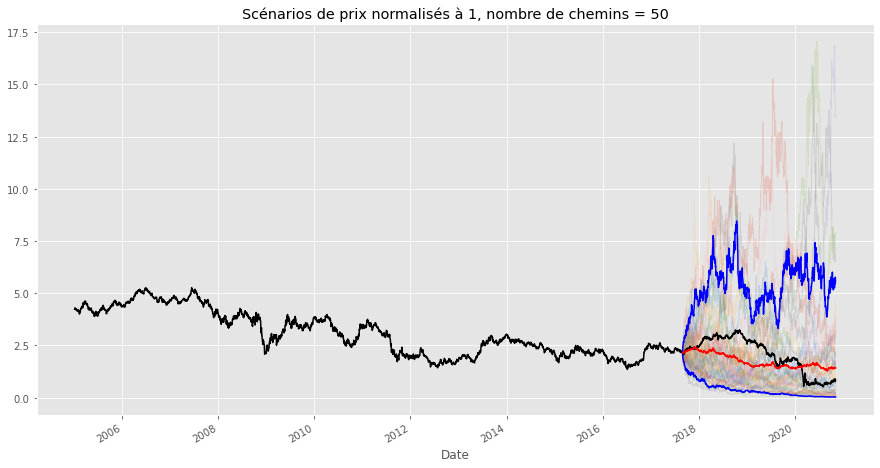

In [138]:
p1 = Series("UST 10 ans", Taux[['UST10Y']], "Taux")
p1.historical_simulation(50)